In [1]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')
## fred = Fred(api_key='MY API KEY')

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## Function

In [4]:
def investment_simulation(price_series, monthly_investment, years):
    """
    특정 자산 가격의 월간 시계열 데이터와 일정한 월 투자 금액을 기반으로
    투자 시작 시점별로 n년 동안의 투자 경과를 시뮬레이션하는 함수.

    Parameters:
        price_series (pd.Series): 월 단위 자산 가격 시계열 데이터 (Index: 날짜)
        monthly_investment (float): 매월 투자하는 금액
        years (int): 투자 기간 (년)

    Returns:
        List[pd.DataFrame]: 각 투자 시작 시점별 매월 투자 결과를 포함한 데이터프레임 리스트
    """
    results = []  # 투자 시뮬레이션 결과를 저장할 리스트
    months = years * 12  # 투자 기간을 월 단위로 변환
    
    for start_idx in range(len(price_series) - months):
        end_idx = start_idx + months  # 투자 종료 월
        
        # 투자 기간 내의 가격 데이터 가져오기
        invest_prices = price_series.iloc[start_idx:end_idx+1]
        
        total_invested = 0  # 총 투자 금액
        total_units = 0  # 총 매수한 자산 개수
        records = []  # 매월 기록 저장
        
        for i in range(len(invest_prices)):
            date = invest_prices.index[i]  # 현재 투자 월
            price = invest_prices.iloc[i]  # 해당 월의 가격
            
            # 매월 투자
            total_invested += monthly_investment
            total_units += monthly_investment / price  # 해당 월의 가격으로 매수
            
            # 현재 평가 금액 계산
            final_value = total_units * price
            
            # 기록 저장
            records.append({
                "Date": date,
                "Total_Invested": total_invested,
                "Total_Units": total_units,
                "Final_Value": final_value
            })
        
        # 데이터프레임 변환 후 리스트에 저장
        results.append(pd.DataFrame(records).set_index("Date"))
    scores = pd.DataFrame([(_df.index[0], (_df['Final_Value'][-1]/_df['Total_Invested'][-1]-1)*100) for _df in results], columns=['Date', 'Total_Return']).set_index('Date')
    return results, scores

## DataLoad

In [5]:
dataset = pd.read_csv('trend_data.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index)

## Simulation

In [6]:
150*30*12

54000

In [59]:
((2000000/(150*30*12))-1 )*100

3603.703703703704

In [53]:
year = 30
month = year*12
simulations, scores = investment_simulation(dataset['TQQQ'].resample('M').first(), 150*1e4, year)

min_index = scores[scores['Total_Return'] == scores['Total_Return'].min()].index[0]
min_index = scores.index.get_loc(min_index)

max_index = scores[scores['Total_Return'] == scores['Total_Return'].max()].index[0]
max_index = scores.index.get_loc(max_index)

worst_case = simulations[min_index][['Total_Invested', 'Final_Value']].head(month)
bset_case = simulations[max_index][['Total_Invested', 'Final_Value']].head(month)

In [54]:
worst_case['return_rate'] = (worst_case['Final_Value']/worst_case['Total_Invested'] - 1)*100

In [55]:
worst_case

,Total_Invested,Final_Value,return_rate
Date,,,
1979-03-31,1500000.0,1.500000e+06,0.000000
1979-04-30,3000000.0,3.325530e+06,10.850994
1979-05-31,4500000.0,5.020849e+06,11.574412
1979-06-30,6000000.0,6.287425e+06,4.790424
1979-07-31,7500000.0,8.604041e+06,14.720550
...,...,...,...
2008-10-31,534000000.0,1.775026e+11,33140.190314
2008-11-30,535500000.0,1.102997e+11,20497.523740
2008-12-31,537000000.0,6.116857e+10,11290.794364


In [56]:
7.988454e+10

79884540000.0

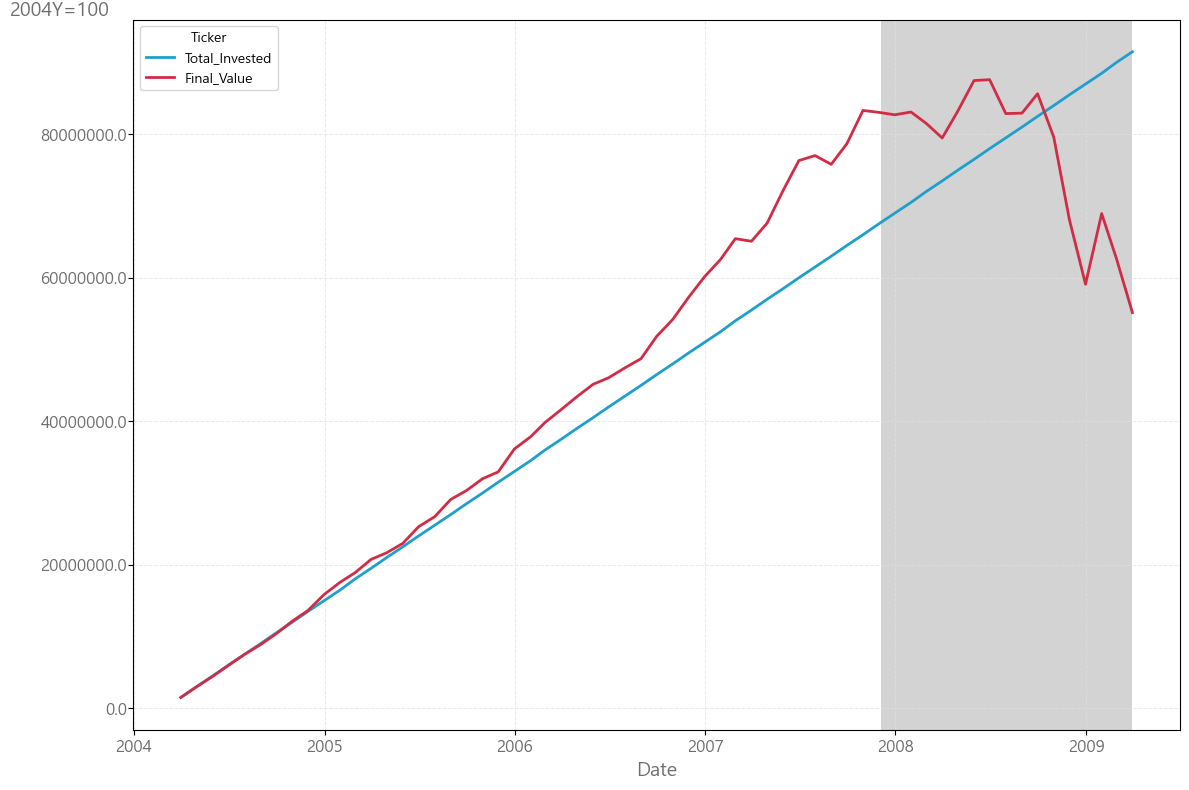

In [13]:
## worst_case.plot()
gm.trend_plot(worst_case, ['Total_Invested', 'Final_Value'], title=False, yscale='linear', colors=[mycolors['color_cont'], mycolors['color_norm']])

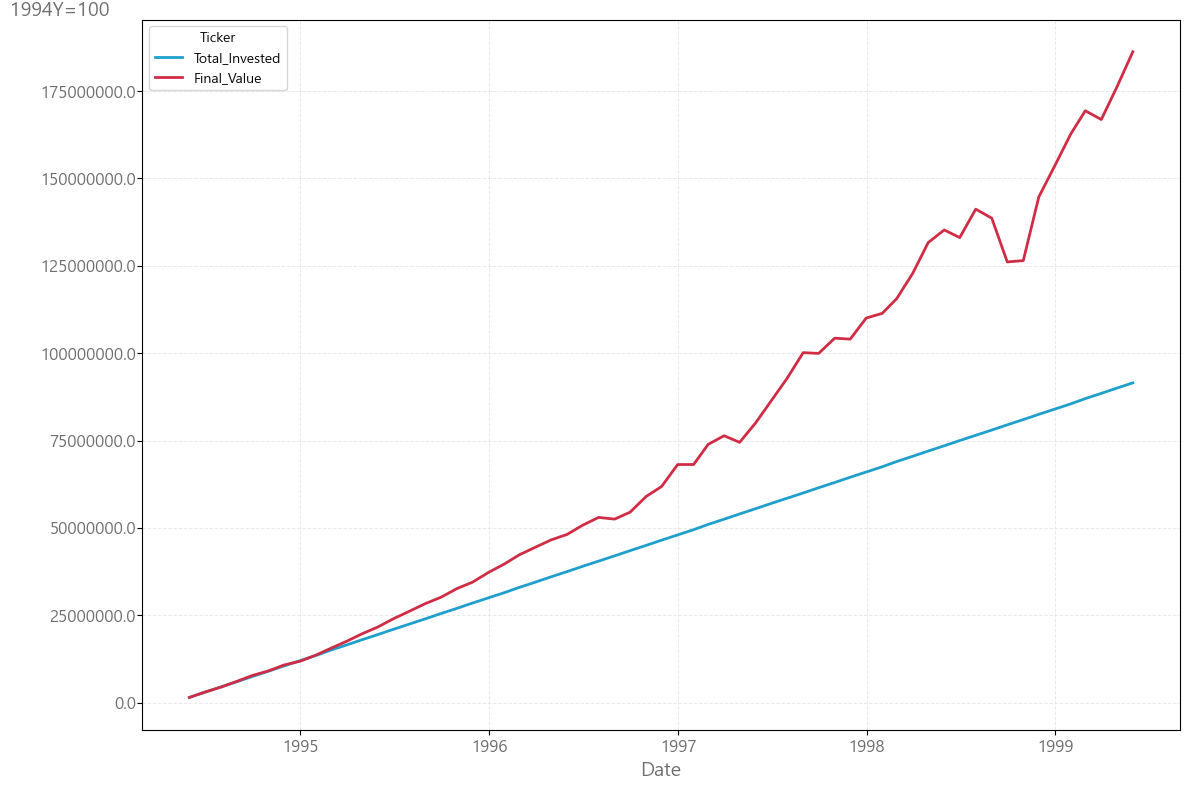

In [14]:
## worst_case.plot()
gm.trend_plot(bset_case, ['Total_Invested', 'Final_Value'], title=False, yscale='linear', colors=[mycolors['color_cont'], mycolors['color_norm']])

In [15]:
scores[min_index:min_index+1]

,Total_Return
Date,
2004-03-31,-39.730566


In [16]:
scores[max_index:max_index+1]

,Total_Return
Date,
1994-05-31,103.528346


In [58]:
150/0.0162

9259.25925925926

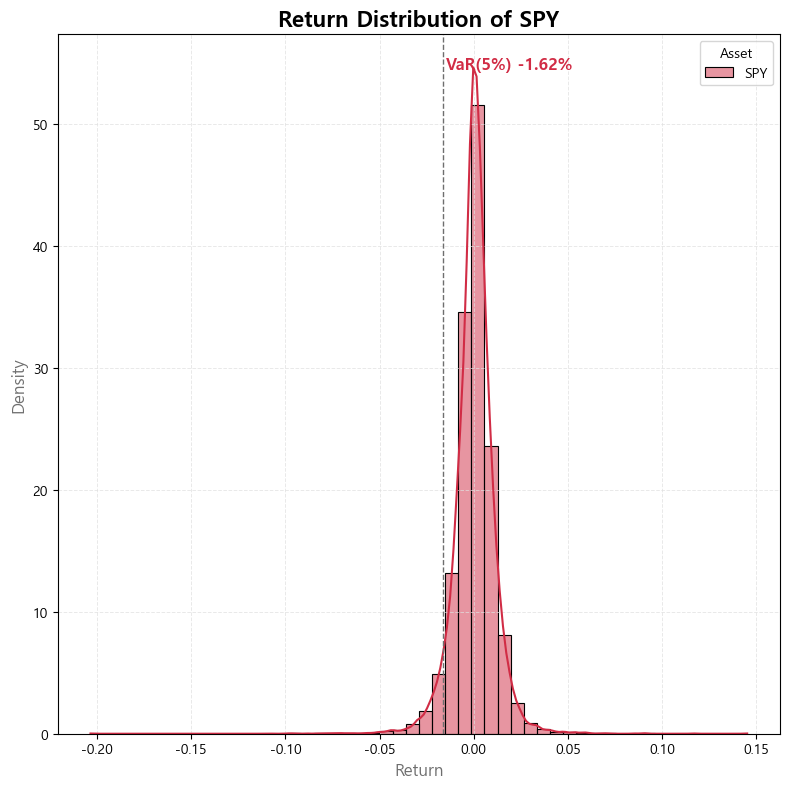

In [57]:
gm.asset_histogram_plot(dataset.pct_change(), ['SPY'], colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], var_value=5)

In [22]:
150 * (100/1.62)

9259.25925925926